In [1]:
import numpy as np
import matplotlib.pylab as plt
import AdaptiveFilters as AF
from statsmodels.tsa.arima_process import arma_generate_sample
from parameters import parameters
%matplotlib inline
# %autoreload 2

In [2]:
compilation = 'compilation.wav'
DBCall = 'Call_0D.wav'
KMCall = 'Call_0K.wav'
bm048a001 = 'bm048a001.wav'     # rate = 12000
bm048a002 = 'bm048a002.wav'     # rate = 12000
bm048a004 = 'bm048a004.wav'
bm048a005 = 'bm048a005.wav'

params = parameters(wavfile=compilation, tsamp=1)
params.load_all(sndtype='stereo')

rate = params.rate  # sampling frequency
snd_mono = params.sound  # data in np array
N = params.N_samples
sampwidth = params.sampwidth

Archivo de entrada formato mono, se mantiene
Filename:             compilation.wav
Sound type:           stereo
Sound dimension:      (5978278L,)
Times windows (s):    1
Rate:                 6000
Sampwidth:            6000
Number of samples:    996


Initial values for x: [-0.38358231 -0.22589271 -0.05963648]
(5L, 1005L) (1005L,)
(5L, 5L) (5L,)


(0, 500)

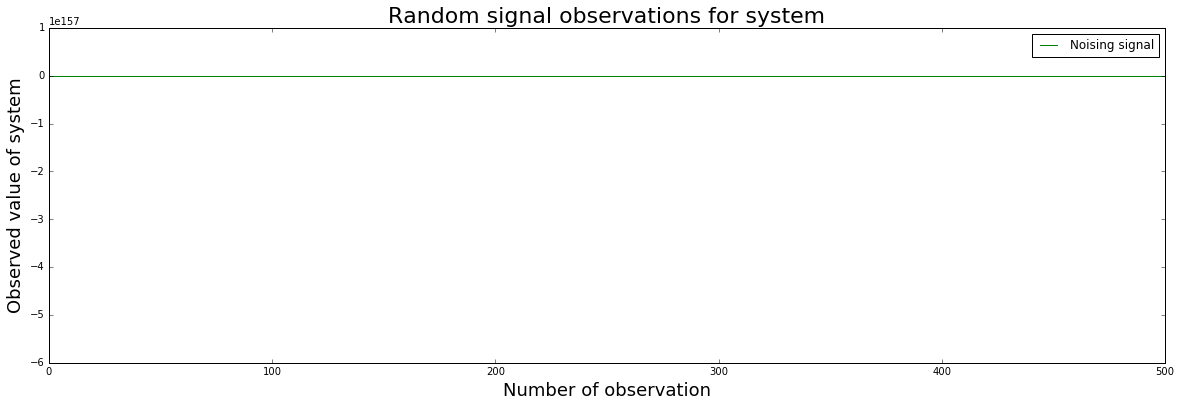

In [14]:
N =  1005   # Number of samples
order = 5   # Order of filter (number of weights)
k = 200 # Values for plot
w = np.array([2, -0.4, 0.75])
'''Create a test function, this is:
x[n] = 2.0*x[n-1] + 0.1*x[n-2] - 4.0*x[n-3] + 0.5*x[n-4] + 11*x[n-5]
where x[n], ..., x[n-4] is a random signal with mean -0.5 and unit variance
and d[n] is the observed process.

'''
d = AF.testfctn1(w, N)
x = np.zeros((order,N))
for i in range(0, N-order):
    x[:, i] = d[i:i+order]
print x.shape, d.shape
R = np.dot(x, x.transpose())
p = np.dot(d, x.transpose())
print R.shape, p.shape
# x, d, w = AF.testfctn2(N=N) # 
plt.figure(figsize=(20,6))
plt.title('Random signal observations for system', fontsize=22)
plt.xlabel('Number of observation', fontsize=18)
plt.ylabel('Observed value of system', fontsize=18)
plt.plot(d, c='g', label='Noising signal')
#plt.plot(x[1, :], c='b', label='Delayed signal at a sample')
plt.legend()
plt.xlim([0, 500])

[ 1.   -0.1  -0.33] [ 1.   0.2 -0.5]
(5L, 2000L)


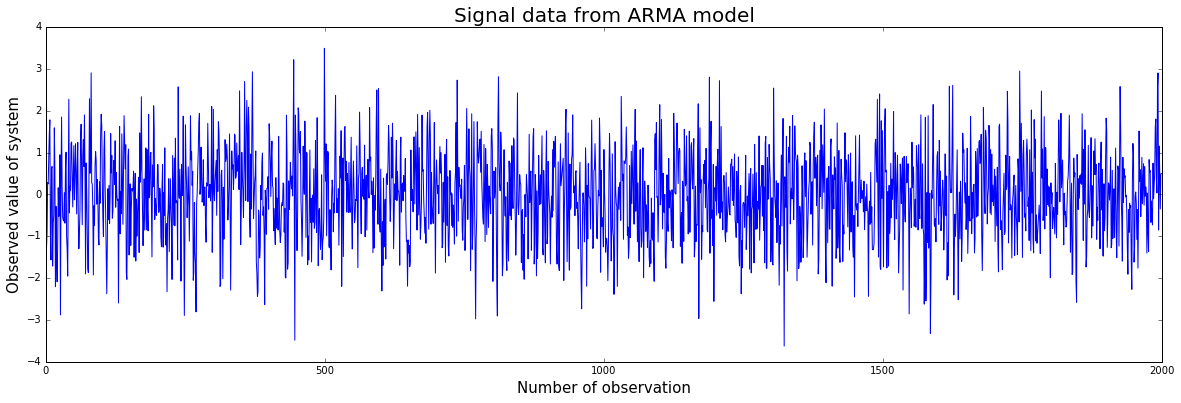

In [5]:
if True:
    arparams = np.array([.1, 0.33])
    maparams =  np.array([.2, -0.5])
    ar = np.r_[1, -arparams] # add zero-lag and negate
    ma = np.r_[1, maparams] # add zero-lag
    print ar, ma
    mu = 0
    sigma = 1
    N_samples = 2000
    order = 5
    d = arma_generate_sample(ar, ma, N_samples)
    x = np.zeros((order, N_samples)) # Regresor matrix
    for i in range(0, N_samples-order):
        x[:, i] = d[i:i+order]

    # model = sm.tsa.ARMA(y, (2, 2)).fit(trend='nc', disp=0)
    # model.params
    print x.shape
    plt.figure(figsize=(20,6))
    plt.plot(d)
    plt.title('Signal data from ARMA model', fontsize=20)
    plt.xlabel('Number of observation', fontsize=15)
    plt.ylabel('Observed value of system', fontsize=15)

LMS Adaptive Filter
0.1
Last weight: [   0.65964976    2.56948463   -2.04623173    1.91296857  104.91169514]
Real weight: [ 0.4   0.1   0.75 -0.5  -0.33]


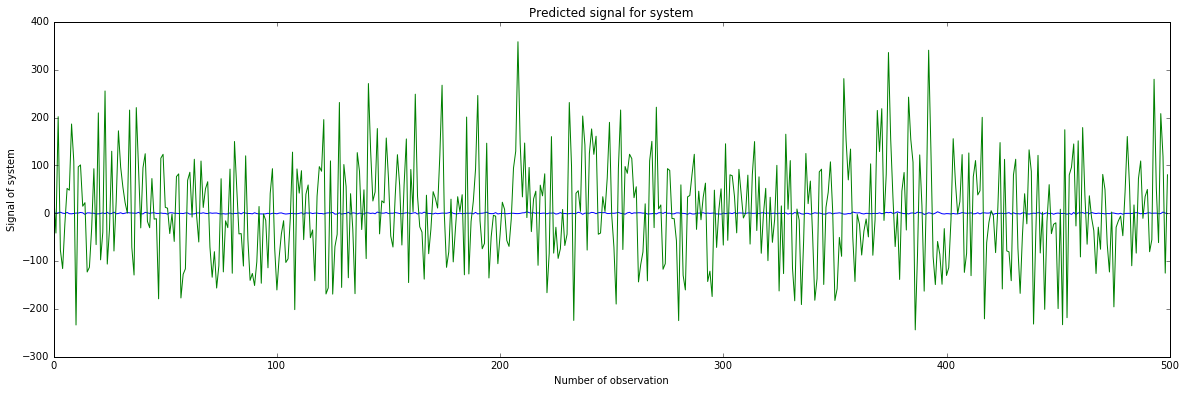

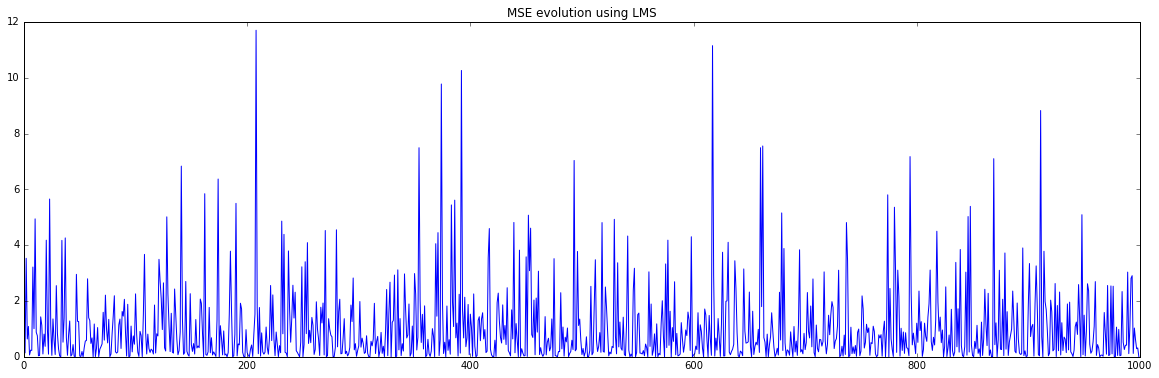

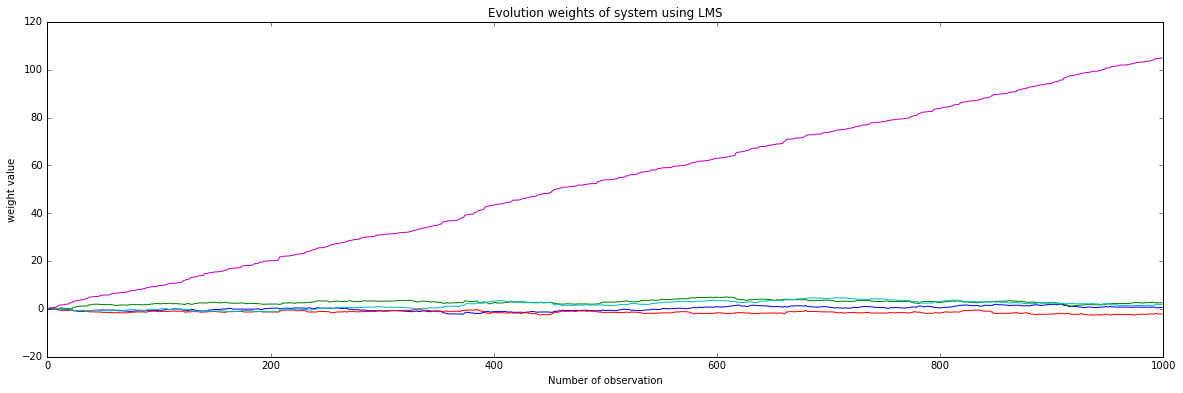

In [22]:
# mu is the learning rate
# eps is the regularisation parameter
# Create an Adaptative filter object.
# LMS filter

LMSFilter = AF.Adaptivefilters(order=order, mu=0.1)
# Calculate the weight from the regressor process X = x[n], ..., x[n-4]
# and observed process d (Remember that it's a observed process in state variables). 
w_lms = LMSFilter.LMS(regressor_process=x, observed_process=d)
# Predict the signal using linear model y = Theta * X
# Get the error evolution (MSE)
e_lms = LMSFilter.e_evolution
# Get the weight evolution
w_evolution = LMSFilter.w_evolution
y_lms = LMSFilter.predict(predictor=LMSFilter.x, weights=w_evolution[999])

print 'Last weight: '+str(w_evolution[999])
print 'Real weight: ' + str(w)
k = 500
plt.figure(figsize=(20,6))
plt.title('Predicted signal for system')
plt.xlabel('Number of observation')
plt.ylabel('Signal of system')
plt.plot(d[0:k], c='b')
plt.plot(y_lms[0:k], c='g')

# Plot the error
plt.figure(figsize=(20,6))
plt.title('MSE evolution using LMS')
plt.plot(e_lms)

# Plot the weights
plt.figure(figsize=(20,6))
plt.title('Evolution weights of system using LMS')
plt.ylabel('weight value')
plt.xlabel('Number of observation')
plt.plot(w_evolution)

NLMS Adaptive Filter
Last weight: [  1.00000000e+00   5.82229495e-12  -7.16936842e-12   6.87735447e-12
  -5.11225465e-12]
[ 0.4   0.1   0.75 -0.5  -0.33]


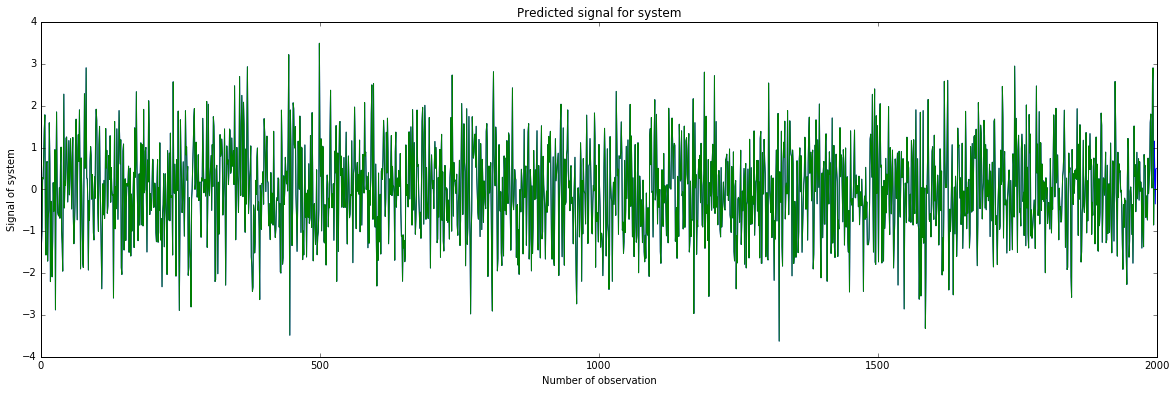

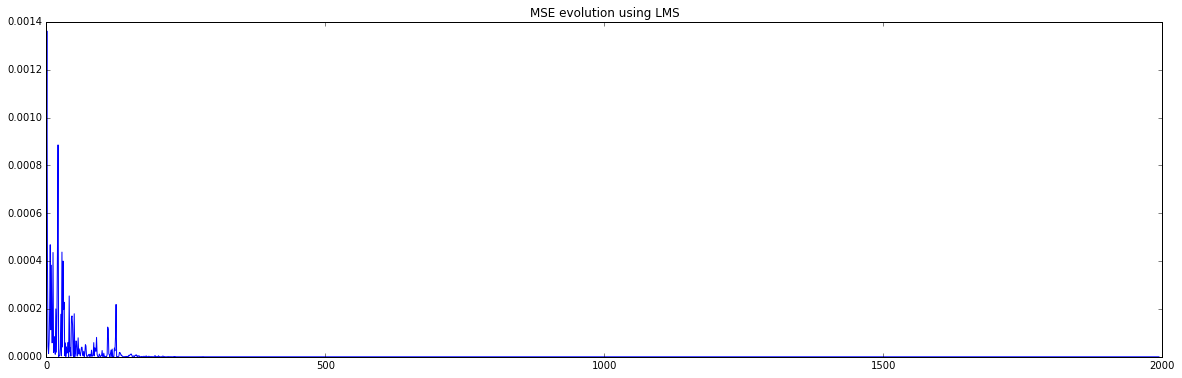

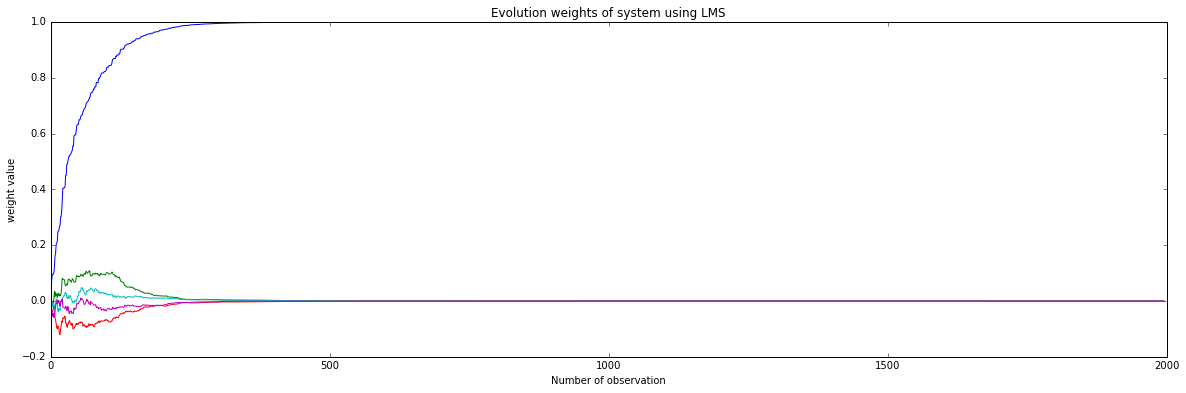

In [7]:

# Train and thest again, using Normalise Least Means Square
NLMSFilter = AF.Adaptivefilters(order=order, mu=0.1, eps=0.09)
w_nlms = NLMSFilter.NLMS(regressor_process=x, observed_process=d)
y_nlms = NLMSFilter.predict(predictor=x, weights=w_nlms)
e_nlms = NLMSFilter.e_evolution
wnlms_evolution = NLMSFilter.w_evolution
# predictor = np.random.random((w.shape[0], N))  # Regressor process
plt.figure(figsize=(20,6))
plt.title('Predicted signal for system')
plt.xlabel('Number of observation')
plt.ylabel('Signal of system')
plt.plot(d, c='b')
plt.plot(y_nlms, c='g')
print w
# Plot the error
plt.figure(figsize=(20,6))
plt.title('MSE evolution using LMS')
plt.plot(e_nlms)

# Plot the weights
plt.figure(figsize=(20,6))
plt.title('Evolution weights of system using LMS')
plt.ylabel('weight value')
plt.xlabel('Number of observation')
plt.plot(wnlms_evolution)


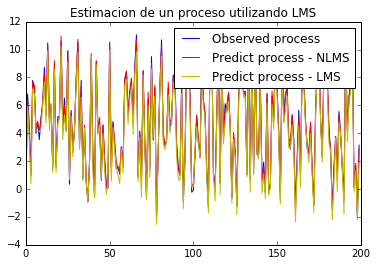

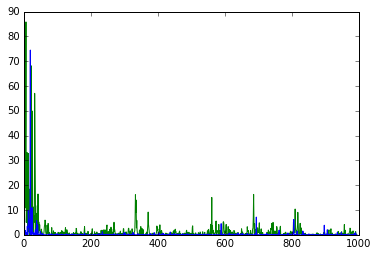

In [20]:
plt.figure()
# plt.plot(d, c='g', label='Observed process')
plt.plot(d[0:k], c='b', label='Observed process')
plt.plot(y_nlms[0:k], c='r', label='Predict process - NLMS')
plt.plot(y_lms[0:k], c='y', label='Predict process - LMS')

plt.title('Estimacion de un proceso utilizando LMS')
plt.legend()

plt.figure('MSE')
plt.plot(e_lms, c='g')
plt.plot(e_nlms, c='b')

plt.show()

NameError: name 'np' is not defined